In [115]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from FilesFunc import files
folders = ["Background", "BH", "Sphaleron"]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
file_amounts = [0, 18, 3]
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal'
        }


filenames_dict = {
    "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL": "Sphal1",
    "PP13-Sphaleron-THR9-FRZ15-NB33-60-NSUBP50": "Sphal2",
    "PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5": "Sphal3",
    "BH_n4_M8": "BH1",
    "BH_n4_M9": "BH2",
    "BH_n4_M9_Mpl9": "BH3",
    "BH_n4_M10": "BH4",
    "BH_n4_M11": "BH5",
    "BH_n4_M12": "BH6",
    "BH_n5_M8": "BH7",
    "BH_n5_M9": "BH8",
    "BH_n5_M10": "BH9",
    "BH_n5_M11": "BH10",
    "BH_n5_M12": "BH11",
    "BH_n6_M8": "BH12",
    "BH_n6_M9": "BH13",
    "BH_n6_M10": "BH14",
    "BH_n6_M11": "BH15",
    "BH_n6_M12": "BH16",
    "BlackMaxOutputFirstRun1": "BH17",
    "BlackMaxOutputFirstRun2": "BH18",
    "ttbar_largejet": "ttbar1",
    "ttbar": "ttbar2"
}


def work_space(path):
    while True:
        if os.path.split(path)[1] != "Programs":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")
work_dir = work_space(os.getcwd())


def remover(old_list, index):
    new_list = [element for element_index, element in enumerate(old_list) if element_index != index]
    return new_list


def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def dropper(dataframe, data_variables):
    to_drop = [col for col in dataframe.columns if col not in data_variables]
    dataframe = dataframe.drop(to_drop, axis = 1)
    return dataframe


def dataframe_retriever(data_path, data_variables):
    from natsort import natsorted, ns
    folders = os.listdir(data_path)
    folder_filenames = [natsorted([filename for filename in os.listdir(data_path + folder)], key = lambda y: y.lower()) for folder in folders]
    folder_filepaths = [[data_path + folder + "/" + filename for filename in folder_filenames[folder_index]] for folder_index, folder in enumerate(folders)]
    folder_filenames = [[filenames_dict[filename[:-len(".csv")]] for filename in filenames] for filenames in folder_filenames]
    dataframes = [[(pd.read_csv(filepath).drop("Unnamed: 0", axis = 1), filename) for filepath, filename in zip(filepaths, filenames)] for filepaths, filenames in zip(folder_filepaths, folder_filenames)]
    return dataframes


def sampler(model_dataframes, file_amounts, data_variables, strings):
    from random import sample
    dataframe_tuples = []
    for file_amount, dataframes in zip(file_amounts, model_dataframes):
        dataframe_tuples.append(sample(dataframes, file_amount)) if type(file_amount) == int else dataframe_tuples.append([dataframe for dataframe in dataframes if dataframe[1] in file_amount])
    dataframe_tuples = [sorted(dataframes, key = lambda x: int(x[1][len(string):])) for dataframes, string in zip(dataframe_tuples, strings)]
    for folder_index, file_amount in enumerate(file_amounts):
        if file_amount == 0:
            dataframe_tuples = remover(dataframe_tuples, folder_index)
    
    foldered_filenames = [[dataframe[1] for dataframe in dataframes] for dataframes in dataframe_tuples]
    foldered_dataframes = [[dropper(dataframe[0], data_variables) for dataframe in dataframes] for dataframes in dataframe_tuples]

    return foldered_dataframes, foldered_filenames

In [116]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


def xy_data(dataframes_input):
    sample_num = np.min([len(dataframe.iloc[:]) for dataframe in unpacker(dataframes_input, [])])
    sampled_model_dataframes = [dataframe.sample(n = sample_num) for dataframe in unpacker(dataframes_input, [])]

    datasets_dict = {"datasets": [dataset_index for dataset_index, dataframes in enumerate(sampled_model_dataframes) for i in range(sample_num)]}
    datasets = pd.DataFrame(datasets_dict)

    model_data = pd.concat(unpacker(sampled_model_dataframes, []))

    return model_data, datasets


def splitter(combine, dataframes_input):
    splits = []
    dataset_index = 0
    for condition, dataframes in zip(combine, dataframes_input):
        if condition:
            start_index = dataset_index
            stop_index = start_index + len(dataframes)
            split = [i for i in range(start_index, stop_index)]
            splits.append(split)
            dataset_index += len(dataframes)
        else:
            for dataframe in dataframes:
                splits.append([dataset_index])
                dataset_index += 1
        
    return splits


def model(dataframes_input, filenames_input, folders, combine):
    xlabels = unpacker([folders[folder_index] if condition else filenames for folder_index, (filenames, condition) in enumerate(zip(filenames_input, combine))], [])

    splits = splitter(combine, dataframes_input)

    x_train, y_train = xy_data(dataframes_input)
    
    
    if len(xlabels) != 2:
        # Define the model and train it
        xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
        xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 4)

    else:
        # Bruk disse om det er 2 forskjellige type dataset, derfor "binary"
        xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
        xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 4)


    # Train model on data
    xgb_model.fit(x_train, y_train)

    return xgb_model, xlabels, splits

In [117]:
data_path = work_dir + "/Hub/VariableData/"
folder_dataframes = dataframe_retriever(data_path, data_variables)

combine_data = True
combine = [True, True, True]
file_amounts = [2, ["BH6", "BH11", "BH16"], ["Sphal2", "Sphal3"]]
strings = ["ttbar", "BH", "Sphal"]

if not combine_data:
    try:
        remove_index = folders.index("Background")
        folders = remover(folders, remove_index)
        folder_dataframes = remover(folder_dataframes, remove_index)
        combine = remover(combine, remove_index)
        file_amounts = remover(file_amounts, remove_index)
        strings = remover(strings, remove_index)
    except:
        pass

In [118]:
data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
data_variables = ["HT", "met", "phi_diff", "ptmax"]

data_variables_dict = {
    "HT": "$H_T$",
    "met": "MET",
    "phi_diff": "$\phi_{diff}$",
    "ptmax": "$P_{Tmax}$",
    "stuff_amount": "Multiplicity"
}

model_dataframes, model_filenames = sampler(folder_dataframes, file_amounts, data_variables, strings)
xgb_model, xlabels, splits = model(model_dataframes, model_filenames, folders, combine)

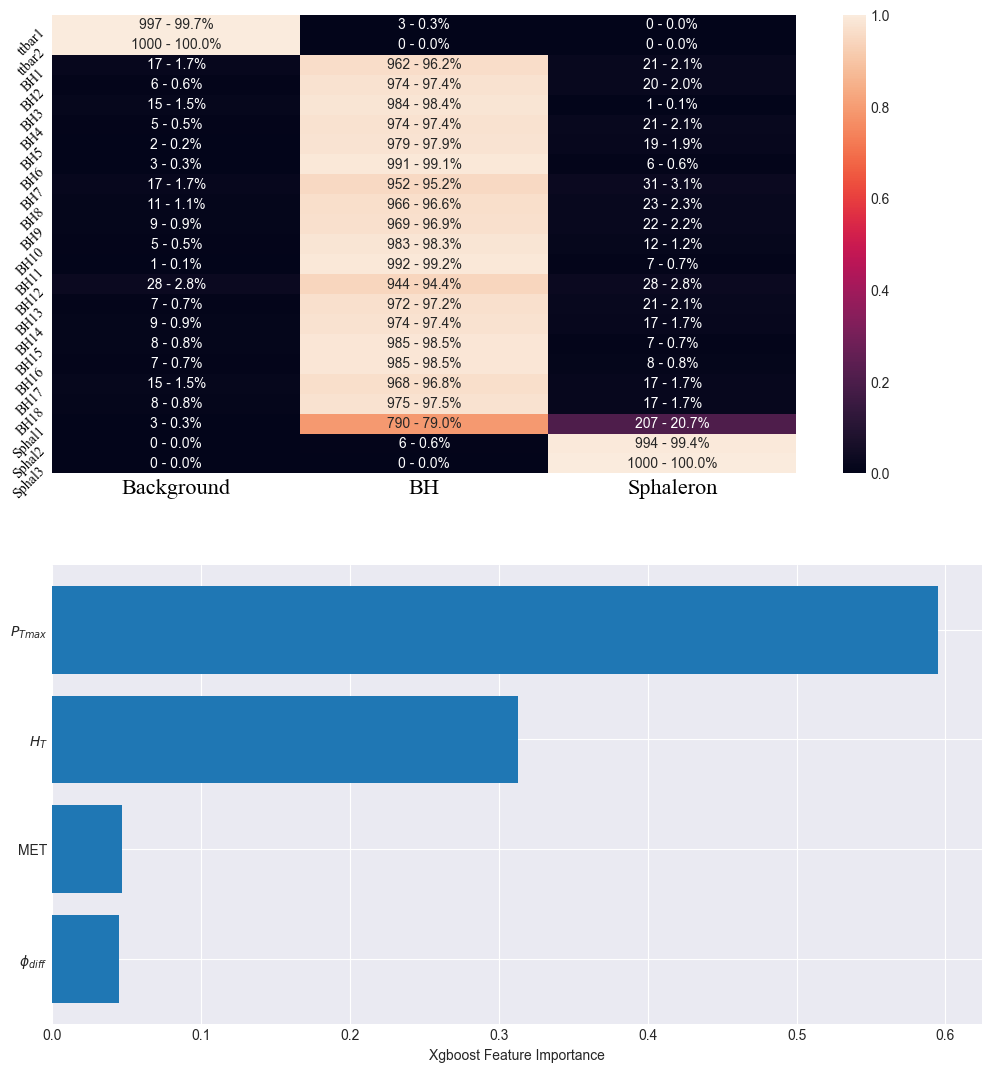

In [124]:
def split_data(y_pred, file_amounts):
    filenum = np.sum([file_amount if type(file_amount) == int else len(file_amount) for file_amount in file_amounts])
    split_num = int(len(y_pred) / filenum)
    y_pred = [y_pred[i * split_num : (i + 1) * split_num] for i in range(filenum)]

    y_pred_data = [tuple(np.round(y_pred[j].count(i) / split_num, 3) for i in range(len(folders))) for j in range(len(y_pred))]
    y_pred_labels = [tuple(str(y_pred[j].count(i)) + " - " + str(np.round(y_pred[j].count(i) * 100 / split_num, 1)) + "%" for i in range(len(folders))) for j in range(len(y_pred))]

    return y_pred_data, y_pred_labels



if False:
    file_amounts = [2, ["BH6", "BH11", "BH16"], 3]
    temp_amounts = [file_amount if type(file_amount) == int else len(file_amount) for file_amount in file_amounts]
    colors = []
    for index, file_amount in enumerate(temp_amounts):
        temp_list = []
        for amount in range(1, 1 + file_amount):
            rgb = [0, 0, 0]
            rgb[index] = (amount + 3) * 1 / (file_amount + 6)
            rgb[int((index + 2) % 3)] = (amount + 3) * 1 / (file_amount + 6)
            temp_list.append(rgb)
        colors.append(temp_list) 
        
    from Plotter import plotter
    figsize = 16
    plot_dataframes, plot_filenames = sampler(folder_dataframes, file_amounts, data_variables, strings)
    plotter(data_variables, plot_dataframes, plot_filenames, colors, filter_strengths = [0.99, 0.95, 1, 0.985, 1], binsizes = [50, 15, 0.2, 25, 0.5], figsize = figsize)


if True:
    file_amounts = [2, 18, 3]
    dataframes_input, filenames_input = sampler(folder_dataframes, file_amounts, data_variables, strings)

    x_test, y_test = xy_data(dataframes_input)
    ylabels = unpacker(filenames_input, [])

    # Make predictions with model
    y_pred = xgb_model.predict(x_test)
    y_pred = [split_index for pred_num in y_pred for split_index, split in enumerate(splits) if pred_num in split]


    y_pred_data, y_pred_labels = split_data(y_pred, file_amounts)


    fig = plt.figure(figsize = (12, 13.1))
    plt.style.use("seaborn-v0_8-dark")
    axs = fig.subplots(2, 1)


    x_ticks = np.arange(len(xlabels))   
    y_ticks = np.arange(len(ylabels))    

    import seaborn as sns

    # Plot confusion matrix
    ax = axs[0]
    sns.heatmap(y_pred_data, annot = y_pred_labels, fmt = "", ax = ax, xticklabels = xlabels, yticklabels = ylabels)
    ax.set_yticklabels(ax.get_yticklabels(), va = "top", rotation = 45, fontdict = font)
    ax.set_xticklabels(ax.get_xticklabels(), fontdict = font, fontsize = 16)


    # Plot variables by importance for prediction
    ax = axs[1]
    ax.grid()
    sorted_idx = xgb_model.feature_importances_.argsort()
    labels = [data_variables_dict[data_variable] for data_variable in data_variables]
    ax.barh(np.array(labels)[sorted_idx], xgb_model.feature_importances_[sorted_idx])
    ax.set_xlabel("Xgboost Feature Importance")
    plt.show()
    plt.close()